# Practical Statistics Chapter 3

### Statistical Experiments and Significance Testing

In [1]:
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm
import math as mt
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def permutation_function(dataframe, data_col, grouping_col, iterations, statistic_function):
    output = {}

    groups = dataframe[grouping_col].value_counts().index
    values = dataframe[grouping_col].value_counts().index

    for x in range(iterations):
        for i in groups:
            sample_amount = dataframe[grouping_col].value_counts()[i]
            sample_data = dataframe[data_col].sample(sample_amount, replace=False).to_list()
            sample_metric = statistic_function(sample_data)
            try:
                output[i].append(sample_metric)
            except (KeyError, AttributeError):
                output[i] = [sample_metric]
    
    final_output = pd.DataFrame(output)
    return final_output

In [7]:
ab_test_data_import = pd.read_csv("data/ab_data.csv")
ab_test_data_import

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [17]:
i = ab_test_data_import[
    (
        (ab_test_data_import["group"] == "treatment")
        == (ab_test_data_import["landing_page"] == "new_page")
    )
    == False
].index

df2 = ab_test_data_import.drop(i)
df2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [20]:
permutation_data = permutation_function(df2, "converted", "group", 10000, np.mean)
permutation_data

,treatment,control
0,0.119805,0.119987
1,0.119406,0.118961
2,0.118181,0.118039
3,0.120837,0.119856
4,0.120046,0.119072
...,...,...
9995,0.118456,0.119904
9996,0.119323,0.119037
9997,0.119275,0.120352
9998,0.119681,0.119787


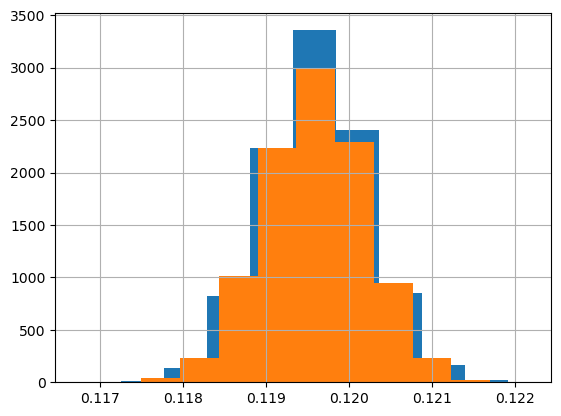

In [21]:
permutation_data["treatment"].hist()
permutation_data["control"].hist()

plt.show()

### Statistical Significance and p-Values

In [23]:
## t-test

res = ss.ttest_ind(df2[df2["group"] == 'control']["converted"],
                    df2[df2["group"] == 'treatment']["converted"],
                    equal_var=False)

print(f'p-value for single sided test : {res.pvalue / 2:.4f}')

p-value for single sided test : 0.0948


In [24]:
### p-value on t-test is greater than 0.05 so we need to reject the null hyphothesis with this data. 

### Anova Test

In [26]:
four_sessions = pd.read_csv("data/four_sessions.csv")

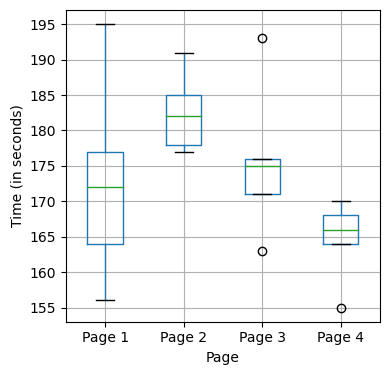

In [37]:
ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [28]:
#we need data wit at least four groups

observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel)
print('Variance:' , observed_variance)


Observed means: <built-in method ravel of numpy.ndarray object at 0x0000018879FEB990>
Variance: 55.426666666666655


In [31]:

def perm_test(df): 
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance])) 

Pr(Prob) 0.08366666666666667


In [32]:
### p-value is too low, so there is no much difference between pages

In [33]:
import statsmodels.formula.api as smf

model = smf.ols('Time ~ Page', data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

res = ss.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time,
                  four_sessions[four_sessions.Page == 'Page 2'].Time,
                  four_sessions[four_sessions.Page == 'Page 3'].Time,
                  four_sessions[four_sessions.Page == 'Page 4'].Time)

print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN
F-Statistic: 1.3699
p-value: 0.0388


### Chi-Square Test

In [34]:
clicks_import = pd.read_csv("data/click_rates.csv")

clicks = clicks_import.pivot(index='Click', columns='Headline')
clicks

Rate                      
Headline Headline A Headline B Headline C
Click                                    
Click            14          8         12
No-click        986        992        988

In [38]:


# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')



Observed chi2: 1.6659
Resampled p-value: 0.4495


In [40]:
chisq, pvalue, df, expected = ss.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')



Observed chi2: 1.6659
p-value: 0.4348


### Power and Sample Size

In [41]:

effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)



Sample Size: 116602.391


c:\Users\zik__\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)


In [42]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
